## Impact of alignment-based deviations w.r.t time

### Importing a log (P2P Process BPIC'19)

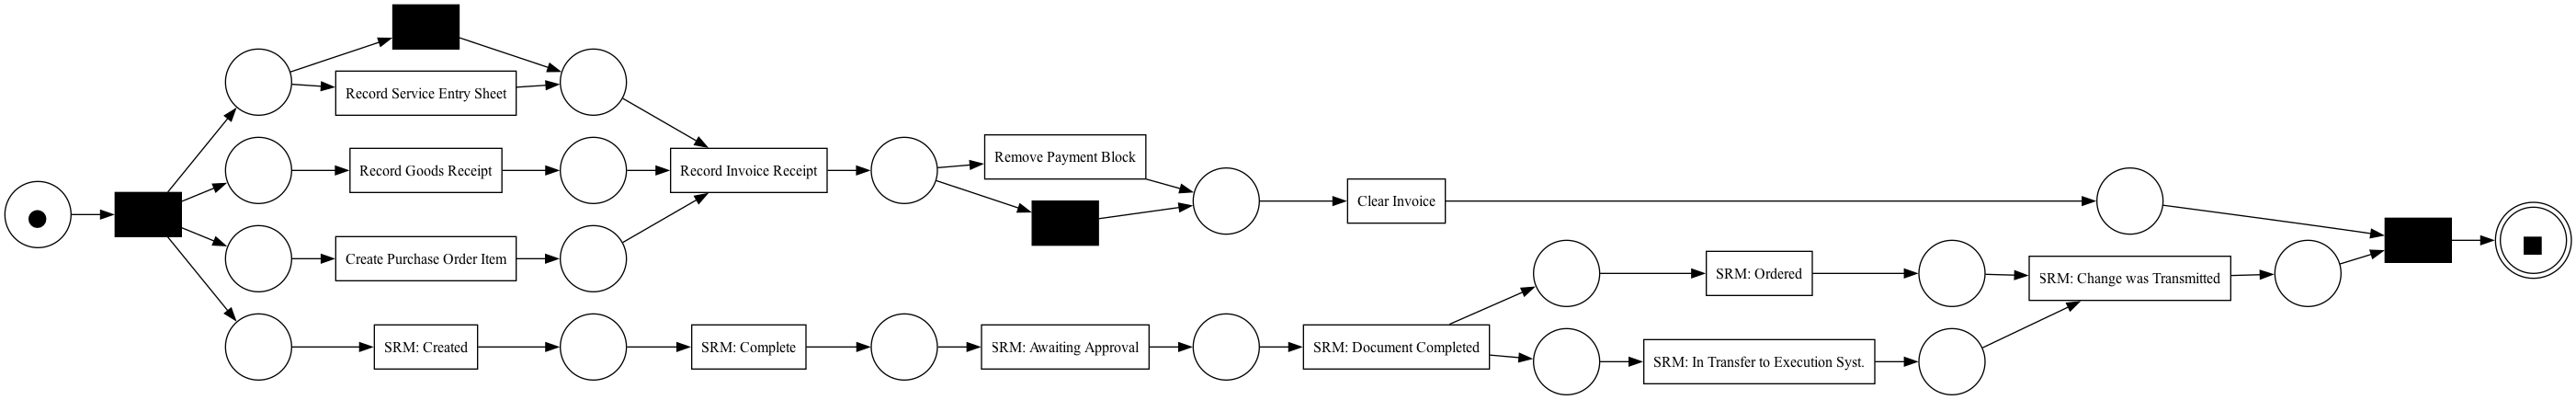

In [1]:
import time
from tqdm import tqdm
import pm4py
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from collections import Counter

from process_atoms.mine.declare.enums.mp_constants import Template
from process_atoms.processatoms import ProcessAtoms
from process_atoms.mine.declare.regexchecker import RegexChecker
import pandas as pd
import seaborn as sns

from process_atoms.models.event_log import EventLog, EventLogSchemaTypes
from process_atoms.models.column_types import (
    CaseID,
    Categorical,
    EventType,
    EventTime,
    Continuous,
)

schema = EventLogSchemaTypes(
    # schema for case-level attributes
    cases={
        "Case ID": CaseID,
        "(case) Company": Categorical,
        "(case) Document Type": Categorical,
        "(case) GR-Based Inv. Verif.": Categorical,
        "(case) Goods Receipt": Categorical,
        "(case) Item": Categorical,
        "(case) Item Category": Categorical,
        "(case) Item Type": Categorical,
        "(case) Name": Categorical,
        "(case) Purch. Doc. Category name": Categorical,
        "(case) Purchasing Document": Categorical,
        "(case) Source": Categorical,
        "(case) Spend area text": Categorical,
        "(case) Spend classification text": Categorical,
        "(case) Sub spend area text": Categorical,
        "(case) Vendor": Categorical,
        "Cumulative net worth (EUR)": Continuous,
    },
    events={
        "Case ID": CaseID,
        "Activity": EventType,
        "Complete Timestamp": EventTime,
        "Resource": Categorical,
    },
)

LOG_PATH = "data/BPI_Challenge_2019.csv"
PROCESS = "BPIC_19"
sub_process = '3-way match, invoice after GR'
MODEL_PATH= "data/"+sub_process+".bpmn"
from data.handling import transform_to_log, transform_to_pn, generate_alignments_adjusted_tracecost_pkl
log = transform_to_log(LOG_PATH)
net, initial_marking, final_marking=transform_to_pn(MODEL_PATH)

### First, detect the deviations per trace and impact dimension (duration of traces in h)

In [2]:
aligned_traces=generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)
dev=[] # stores all deviations that happened
dev_pairs=[] # store them as tuples
for i, trace in enumerate(log):
    no_moves=len(aligned_traces[i]['alignment'])
    for j in range(0,len(aligned_traces[i]['alignment'])):
        if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
            next # we do not care for simultaneous or silent moves
        else:
            if not str(aligned_traces[i]['alignment'][j]) in dev:
                dev.append(str(aligned_traces[i]['alignment'][j]))
                dev_pairs.append((aligned_traces[i]['alignment'][j][0],aligned_traces[i]['alignment'][j][1]))
collect_data=pd.DataFrame(data=0, index=range(len(log)), columns=dev)
collect_data['duration']=None
collect_data['case_id']=None
for i, ali in enumerate(aligned_traces):
    collect_data['case_id'][i]=log[i].attributes['concept:name']
    collect_data['duration'][i]=(log[i][len(log[i])-1]['time:timestamp']-log[i][0]['time:timestamp']).total_seconds()/60/60
    for c in range(len(dev)):
        d = dev[c]
        dp = dev_pairs[c]
        if dp in ali['alignment']:
            collect_data[d][i]=1
collect_data['duration']=collect_data['duration'].astype(float)

aligning log, completed variants ::   0%|          | 0/4228 [00:00<?, ?it/s]

### Quantify the impact of each deviation on duration based on Conditional Average Treatment Effect (CATE)

In [15]:
from dowhy import CausalModel as dowhymodel
from dowhy import gcm
import networkx as nx
import ast



cates = {}
for d in dev:

    graph = f'digraph {{ "{d}" -> "duration" }}'

    model = dowhymodel(
        data=collect_data,
        treatment=d,
        outcome='duration',
        graph=graph,
        instruments=list(collect_data.drop(columns=d).columns)
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    cates[d] = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True
    ).value


In [16]:
cates

{"('Vendor creates invoice', '>>')": 1737.7307035699914,
 "('SRM: In Transfer to Execution Syst.', '>>')": 4292.862973246378,
 "('SRM: Transfer Failed (E.Sys.)', '>>')": 6141.6834938181155,
 "('Record Goods Receipt', '>>')": -249.6948605445964,
 "('Record Service Entry Sheet', '>>')": -612.6475628957239,
 "('Cancel Goods Receipt', '>>')": 382.4724049150518,
 "('>>', 'Record Goods Receipt')": -1415.3424355207917,
 "('>>', 'Record Invoice Receipt')": -2227.942361084534,
 "('>>', 'Clear Invoice')": -1738.12150072939,
 "('Change Delivery Indicator', '>>')": 1093.9072493114727,
 "('Record Invoice Receipt', '>>')": 3238.182249225438,
 "('Clear Invoice', '>>')": 3918.52288358979,
 "('SRM: Created', '>>')": 2881.8665844686057,
 "('SRM: Complete', '>>')": 2881.8665844686057,
 "('SRM: Awaiting Approval', '>>')": 2881.8665844686057,
 "('SRM: Document Completed', '>>')": 2819.7902770908468,
 "('SRM: Ordered', '>>')": 2853.0216408228343,
 "('SRM: Deleted', '>>')": 2881.8665844686057,
 "('Change Pri

### Then assign severity based on severity function

In [17]:
def severity(value):
    if value == 0:
        return "neutral"
    elif -100 <= value < 0:
        return "low negative"
    elif -1000 <= value < -100:
        return "medium negative"
    elif -10000 <= value < -1000:
        return "high negative"
    elif value < -10000:
        return "critical negative"
    elif 0 < value <= 100:
        return "low positive"
    elif 100 < value <= 1000:
        return "medium positive"
    elif 1000 < value <= 10000:
        return "high positive"
    elif value > 10000:
        return "critical positive"
    else:
        return "undefined"


severities = {}
for deviation, penalty in cates.items():
    severities[deviation] = severity(penalty)

In [20]:
counter = Counter(severities.values())

print(counter)

Counter({'high positive': 21, 'high negative': 11, 'medium positive': 9, 'medium negative': 4, 'low positive': 1, 'low negative': 1})


In [19]:
severities

{"('Vendor creates invoice', '>>')": 'high positive',
 "('SRM: In Transfer to Execution Syst.', '>>')": 'high positive',
 "('SRM: Transfer Failed (E.Sys.)', '>>')": 'high positive',
 "('Record Goods Receipt', '>>')": 'medium negative',
 "('Record Service Entry Sheet', '>>')": 'medium negative',
 "('Cancel Goods Receipt', '>>')": 'medium positive',
 "('>>', 'Record Goods Receipt')": 'high negative',
 "('>>', 'Record Invoice Receipt')": 'high negative',
 "('>>', 'Clear Invoice')": 'high negative',
 "('Change Delivery Indicator', '>>')": 'high positive',
 "('Record Invoice Receipt', '>>')": 'high positive',
 "('Clear Invoice', '>>')": 'high positive',
 "('SRM: Created', '>>')": 'high positive',
 "('SRM: Complete', '>>')": 'high positive',
 "('SRM: Awaiting Approval', '>>')": 'high positive',
 "('SRM: Document Completed', '>>')": 'high positive',
 "('SRM: Ordered', '>>')": 'high positive',
 "('SRM: Deleted', '>>')": 'high positive',
 "('Change Price', '>>')": 'high positive',
 "('SRM: Chan